# Recurrent Neural Networks

Recurrent Neural Networks (RNNs) represent a powerful class of neural networks specifically designed to handle sequential data and variable-length sequences. Unlike traditional feedforward neural networks, which process each input independently, RNNs have connections that form directed cycles, allowing them to exhibit dynamic temporal behavior.

At its core, an RNN architecture includes recurrent connections that enable the network to persist information across time steps, making them particularly effective for tasks such as time series prediction, natural language processing, speech recognition, and more. This inherent ability to capture temporal dependencies makes RNNs well-suited for tasks where the input data's context and ordering are essential.

## Libraries

In [ ]:
# !pip install torch

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
from google.colab import drive
from scipy.signal import resample
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report

## Utilities

Here, some utility functions are defined. In particular, `train` and `test` are the functions used to train and test models, respectively.

In [2]:
# Training function.
def train(epoch, model, loader, criterion, optimizer, device='cpu'):
    l = 0
    for data in tqdm(loader, desc=f'Epoch {epoch+1:03d}'):
        x = data[0].to(device)
        y = data[1].to(device)
        out = model(x)
        loss = criterion(out, y)
        l += loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return l

# Test function.
def test(model, loader, criterion, device='cpu'):
    l = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in loader:
            x = data[0].to(device)
            y = data[1].to(device)
            out = model(x)
            l += criterion(out, y)
            _, pred = torch.max(out.data, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            y_true += y.tolist()
            y_pred += pred.tolist()
    return l, correct / total, f1_score(y_true, y_pred, average='macro'), y_true, y_pred

The `CustomDataset` class encapsulates the functionality required to prepare custom data for training deep learning models in PyTorch. By implementing methods such as `__len__` and `__getitem__`, it conforms to the interface expected by PyTorch's `DataLoader`, which is used to iterate over batches of data during training or evaluation.

In [3]:
# Custom dataset, as we discussed in the first lecture (PyTorch Basics).
class CustomDataset(Dataset):

    # Stores the data.
    def __init__(self, x, y=None, transforms=None):
        super().__init__()
        self.x = x
        self.y = y
        self.transforms = transforms

    # Returns the length of the dataset.
    def __len__(self):
        return self.x.shape[0]

    # Returns a (x, y) pair from the dataset.
    def __getitem__(self, idx):
        x = self.x.iloc[idx, :]
        if self.transforms is not None:
            x = self.transforms(x)
        x = torch.tensor(x).float().unsqueeze(-1)
        y = torch.tensor([self.y.iloc[idx]]).type(torch.LongTensor).squeeze()
        return x, y

## Data

We will use the [MIT-BIH Arrhythmia](https://physionet.org/content/mitdb/1.0.0/) dataset, which can be downloaded from Kaggle [here](https://www.kaggle.com/datasets/shayanfazeli/heartbeat). This dataset contain ambulatory ECG recordings and defines a multiclass classification problem.

To run the following cells, you should first download the dataset and then upload the two files, `mitbih_train.csv` and `mitbih_test.csv`, here on Google Colab. Otherwise, you can upload the files on Google Drive and access them by connecting Colab to Drive.

In [ ]:
# Connect Google Drive.
drive.mount('/content/drive')

Each sample of the dataset defines a univariate time-series composed of $187$ time-steps. The last column of each sample stores the specific class label.

In [ ]:
# Read train and test data.
df_train = pd.read_csv('drive/MyDrive/mitbih_train.csv', header=None)
df_test = pd.read_csv('drive/MyDrive/mitbih_test.csv', header=None)

# Training dataframe.
df_train

The distribution of classes in our dataset is significantly imbalanced, highlighting a crucial consideration in model evaluation. Relying solely on accuracy as a metric may not provide an accurate reflection of the model's performance, as it could be disproportionately influenced by the majority class. To address this imbalance, we need to explore alternative evaluation metrics and strategies. Augmenting the minority classes is one viable approach to mitigate this issue, but others can be considered (e.g., using class weights in the evaluation of the loss function).

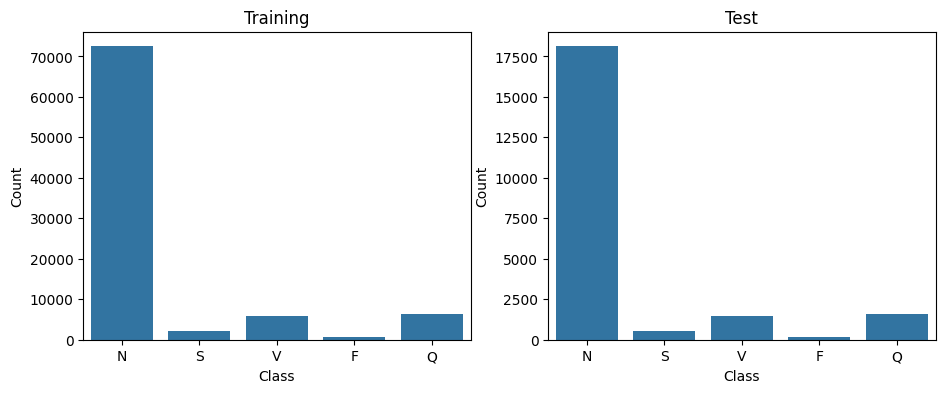

In [ ]:
# From label index to label name.
labels_map = {
    0: 'N', # Normal
    1: 'S', # Fusion of paced and normal
    2: 'V', # Premature ventricular contraction
    3: 'F', # Atrial premature
    4: 'Q'  # Fusion of ventricular and normal
}

# Plot distributions.
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
sns.countplot(x=df_train[df_train.shape[1] - 1], ax=ax[0])
sns.countplot(x=df_test[df_test.shape[1] - 1], ax=ax[1])
ax[0].set_title('Training')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')
ax[0].set_xticks(list(labels_map.keys()))
ax[0].set_xticklabels(list(labels_map.values()))
ax[1].set_title('Test')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')
ax[1].set_xticks(list(labels_map.keys()))
ax[1].set_xticklabels(list(labels_map.values()))
plt.show()

The purpose of plotting sample data is to visually inspect the waveform patterns associated with different cardiac rhythms represented by the labels. This allows for a qualitative assessment of the data distribution and can aid in understanding the characteristics of each rhythm type.

Each subplot in the grid represents a random sample from the dataset, with the waveform plotted on the y-axis and the sample index on the x-axis. The title of each subplot indicates the corresponding cardiac rhythm type based on the label mapping, providing context for the displayed waveform.

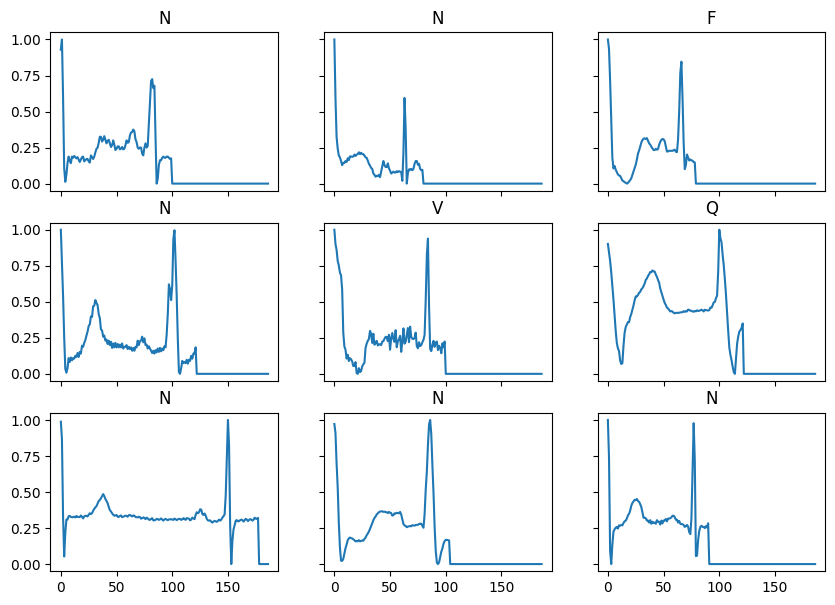

In [ ]:
# Plot some data.
rows, cols = 3, 3
fig, ax = plt.subplots(rows, cols, figsize=(10, 7), sharex=True, sharey=True)
for r in range(rows):
    for c in range(cols):
        sample = df_train.sample(1).values.flatten()
        y = labels_map[sample[-1]]
        ax[r, c].plot(sample[:-1])
        ax[r, c].set_title(y)
plt.show()

### Data Preprocessing and Augmentation

This code cell defines three classes (`Stretch`, `Amplify`, and `Augment`) for randomly augmenting input signals. Each class implements a different signal augmentation technique:

- The `Stretch` class randomly stretches the input signal by resampling it to a new length. The stretching factor is randomly chosen within a certain range. The length of the stretched signal is either shorter or longer than the original signal, but then gets cropped to be of the same length of the original signal.

- The `Amplify` class randomly amplifies the input signal by applying a random scaling factor. The scaling factor is determined by a random value between $-0.5$ and $0.5$, which controls the degree of amplification.

- The `Augment` class combines multiple augmentation techniques specified in the `aug_list`. During the augmentation process, each augmentation technique in the list is randomly applied to the input signal with a $50\%$ probability.

In [ ]:
# Randomly stretches the signal.
class Stretch:
    def __init__(self):
        pass

    def __call__(self, x):
        n = x.shape[0]
        l = int(n * (1 + (random.random() - 0.5) / 3))
        y = resample(x, l)
        if l < n:
            y_ = np.zeros(shape=(n,))
            y_[:l] = y
        else:
            y_ = y[:n]
        return y_

    def __repr__(self):
        return 'Stretch'

# Randomly amplifies the signal.
class Amplify:
    def __init__(self):
        pass

    def __call__(self, x):
        alpha = (random.random() - 0.5)
        factor = -alpha * x + (1 + alpha)
        return x * factor

    def __repr__(self):
        return 'Amplify'

# Randomly augments the input signal.
class Augment:
    def __init__(self, aug_list, verbose=False):
        self.aug_list = aug_list
        self.verbose = verbose

    def __call__(self, x):
        augs = ''
        for i, aug in enumerate(self.aug_list):
            if np.random.binomial(1, 0.5) == 1:
                x = aug(x)
                augs += f'{aug}, ' if i < len(self.aug_list) - 1 else f'{aug}'
        if not self.verbose:
            return x
        return x, augs

An instance of the `Augment` class is created, and signal augmentations are applied to sample data from the training dataset. The augmented samples are then plotted alongside the original samples to visualize the effects of the augmentation techniques.

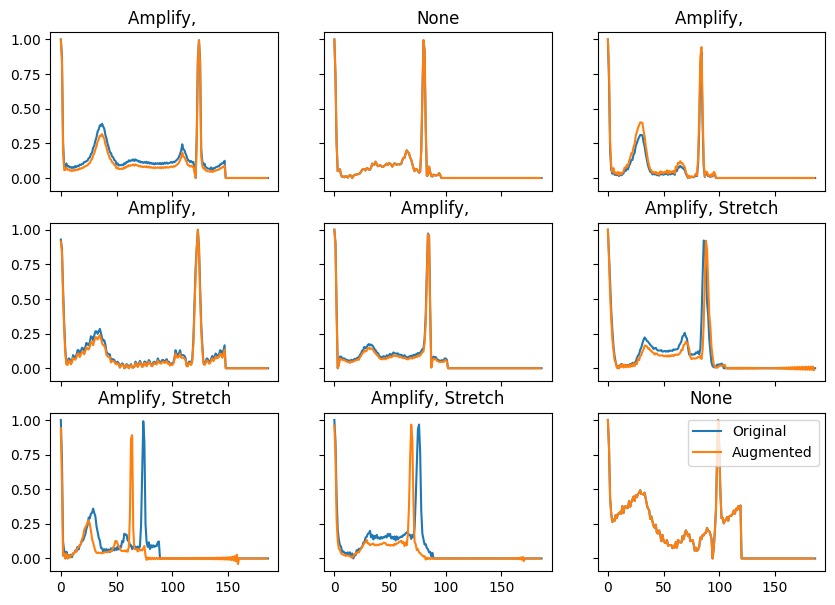

In [ ]:
# New Augment object.
augment = Augment([Amplify(), Stretch()], True)

# Plot augmentations.
rows, cols = 3, 3
fig, ax = plt.subplots(rows, cols, figsize=(10, 7), sharex=True, sharey=True)
for r in range(rows):
    for c in range(cols):
        sample = df_train.sample(1).values.flatten()
        aug_sample, augs = augment(sample[:-1])
        y = labels_map[sample[-1]]
        ax[r, c].plot(sample[:-1])
        ax[r, c].plot(aug_sample[:-1])
        ax[r, c].set_title(augs if augs != '' else 'None')
plt.legend(['Original', 'Augmented'])
plt.show()

 The data processing pipeline is set up for training and testing a neural network model using PyTorch. This includes defining the batch size and creating `Dataset` plus `DataLoader` objects for both training and testing datasets.

In [ ]:
# Batch size.
batch_size = 64

# New Augment object.
augment = Augment([Amplify(), Stretch()])

# Creating the Dataset objects.
train_dataset = CustomDataset(df_train.iloc[:, :-1], df_train.iloc[:, -1], transforms=augment)
test_dataset = CustomDataset(df_test.iloc[:, :-1], df_test.iloc[:, -1])

# Creating the DataLoader objects.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In order to feed the input data to an RNN model, we need each time-series to be tensors in $\mathbb{R}^{S \times H_{in}}$, where $S = 187$ represents the sequence length and $H_{in} = 1$ represents the input size. Indeed, our time-series consider one real value at each possible time-step. Thus, each batch of data will be a tensor in $\mathbb{R}^{N \times S \times H_{in}}$, where $N$ is the chosen batch size.

In [ ]:
# Print the shape of a batch.
for x, y in train_loader:
    print(f'x: {x.shape}, y: {y.shape}')
    break

x: torch.Size([512, 187, 1]), y: torch.Size([512])


## Model Definition

In [ ]:
# Device configuration.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Model hyperparameters.
input_size = 1
hidden_size = 32
num_layers = 2
num_classes = 5

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))  # out: (batch size, seq length, hidden size)
        out = self.fc(out[:, -1, :]) # out: (batch size, num classes)
        return out

# New model.
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

## Training and Test

In [ ]:
# Training hyperparameters.
num_epochs = 10
learning_rate = 0.0001

In [ ]:
# Loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and test.
for epoch in range(num_epochs):
    train_loss = train(epoch, model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, test_f1, y_true, y_pred = test(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1:03d}: training loss {train_loss:.4f}, test loss {test_loss:.4f}, test acc {test_acc:.4f}, test f1 {test_f1:.4f}')

In [ ]:
print(classification_report(y_true, y_pred, zero_division=0))

In [ ]:
# List of training labels.
train_targets = list(df_train[df_train.shape[1] - 1])

# Computing class weights based on class frequency.
cls_weights = torch.from_numpy(compute_class_weight('balanced',
                                                    classes=np.unique(train_targets),
                                                    y=train_targets))

# Resulting array of weights.
weights = cls_weights[train_targets]

# Weighted random sampler. Used to consider copies of minority classes.
sampler = torch.utils.data.WeightedRandomSampler(weights,
                                                 len(train_targets),
                                                 replacement=True)

# Train loader.
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=batch_size)

In [ ]:
# New model.
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and test.
for epoch in range(num_epochs):
    train_loss = train(epoch, model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, test_f1, y_true, y_pred = test(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1:03d}: training loss {train_loss:.4f}, test loss {test_loss:.4f}, test acc {test_acc:.4f}, test f1 {test_f1:.4f}')

In [ ]:
print(classification_report(y_true, y_pred, zero_division=0))